Ellion Blessan <br>
ellionblessan@gmail.com

Dataset: [Emotions in text | Kaggle](https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text)

# Importing dependencies

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import os
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('Emotion_final.csv')
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


# Dataset visualization

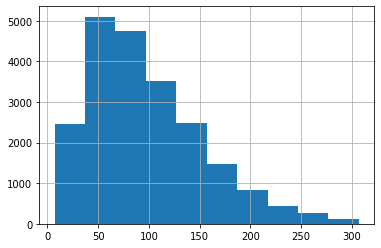

In [11]:
df.Text.str.len().hist() # length of each text

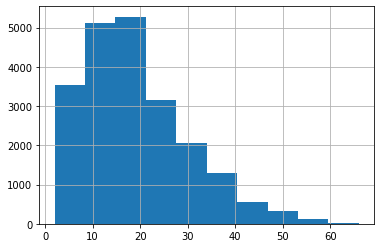

In [12]:
df.Text.str.split().map(lambda x: len(x)).hist() # word count in each text

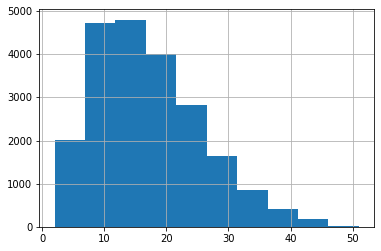

In [13]:
df.Text.apply(lambda x: len(set(str(x).split()))).hist() # unique word count in each text

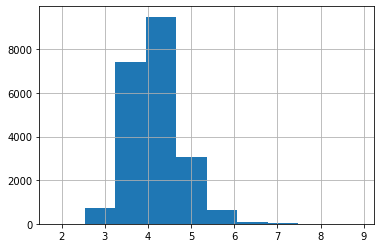

In [16]:
# mean word length in each text
df.Text.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

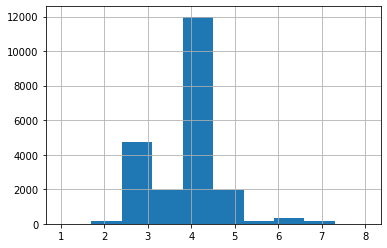

In [20]:
# median word length in each text
df.Text.apply(lambda x: np.median([len(w) for w in str(x).split()])).hist()

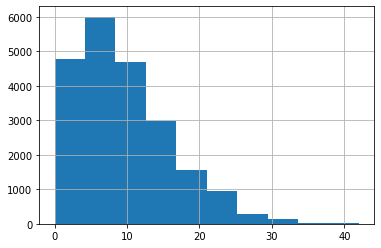

In [22]:
# stop word count
df.Text.apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words])).hist()

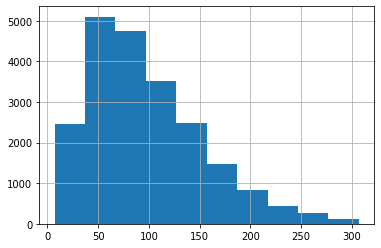

In [23]:
# character count
df.Text.apply(lambda x: len(str(x))).hist()

In [18]:
df.value_counts(df.Emotion)

Emotion
happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
dtype: int64

# Resampling dataset

In [6]:
y = df.Emotion
X = df.drop('Emotion', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=25)
X = pd.concat([X_train, y_train], axis=1)

In [7]:
anger = X[X.Emotion=='anger']
fear = X[X.Emotion=='fear']
happy = X[X.Emotion=='happy']
love = X[X.Emotion=='love']
sadness = X[X.Emotion=='sadness']
surprise = X[X.Emotion=='surprise']

In [8]:
anger_downsampled = resample(anger, replace=False, n_samples=len(fear), random_state=25)
happy_downsampled = resample(happy, replace=False, n_samples=len(fear), random_state=25)
love_upsampled = resample(love, replace=True, n_samples=len(fear), random_state=25)
sadness_downsampled = resample(sadness, replace=False, n_samples=len(fear), random_state=25)
surprise_upsampled = resample(surprise, replace=True, n_samples=len(fear), random_state=25)

In [9]:
resampled_df = pd.concat([anger_downsampled, fear, happy_downsampled,
                          love_upsampled, sadness_downsampled, surprise_upsampled])
resampled_df

,Text,Emotion
11365,i feel i was wronged,anger
19749,ive come to appreciate in the uk where the gen...,anger
2512,i really feel like i m wading in dangerous wat...,anger
6046,i am posting about a past event where i am fee...,anger
7153,i feel disrespected and insulted,anger
...,...,...
20813,Her lovely face reflecting her complete and ut...,surprise
1493,i sit here looking at the sentence i just type...,surprise
18227,i cant seem to get passed feeling stunned,surprise
6850,im not sure how i feel im shocked honestly,surprise


In [10]:
resampled_df.value_counts(resampled_df.Emotion)

Emotion
anger       2128
fear        2128
happy       2128
love        2128
sadness     2128
surprise    2128
dtype: int64

In [ ]:
category = pd.get_dummies(resampled_df.Emotion)
new_df = pd.concat([resampled_df, category], axis=1)
new_df = new_df.drop(columns='Emotion')
new_df

,Text,anger,fear,happy,love,sadness,surprise
11365,i feel i was wronged,1,0,0,0,0,0
19749,ive come to appreciate in the uk where the gen...,1,0,0,0,0,0
2512,i really feel like i m wading in dangerous wat...,1,0,0,0,0,0
6046,i am posting about a past event where i am fee...,1,0,0,0,0,0
7153,i feel disrespected and insulted,1,0,0,0,0,0
...,...,...,...,...,...,...,...
20813,Her lovely face reflecting her complete and ut...,0,0,0,0,0,1
1493,i sit here looking at the sentence i just type...,0,0,0,0,0,1
18227,i cant seem to get passed feeling stunned,0,0,0,0,0,1
6850,im not sure how i feel im shocked honestly,0,0,0,0,0,1


# Cleaning dataset

In [ ]:
wnl = WordNetLemmatizer()

def remove_punctuation(data):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  clean_text = tokenizer.tokenize(data)
  return(clean_text)
  new_df.Text = new_df.Text.apply(lambda x: x.remove_punctuation(x))

new_df.Text = new_df.Text.apply(lambda x: x.lower())

def remove_stopwords(data):
  word_tokens = word_tokenize(data)
  clean_text = [words for words in word_tokens if not words.lower() in stop_words]
  clean_text = []
  for words in word_tokens:
    if words not in stop_words:
      clean_text.append(words)
  return(clean_text)
  new_df.Text = new_df.Text.apply(lambda x: x.remove_stopwords(x))

def lem_word(data):
  word_tokens = word_tokenize(data)
  for words in word_tokens:
    words = wnl.lemmatize(words)
  return(words)
  new_df.Text = new_df.Text.apply(lambda x: x.lem_word(x))

In [ ]:
new_df

,Text,anger,fear,happy,love,sadness,surprise
11365,i feel i was wronged,1,0,0,0,0,0
19749,ive come to appreciate in the uk where the gen...,1,0,0,0,0,0
2512,i really feel like i m wading in dangerous wat...,1,0,0,0,0,0
6046,i am posting about a past event where i am fee...,1,0,0,0,0,0
7153,i feel disrespected and insulted,1,0,0,0,0,0
...,...,...,...,...,...,...,...
20813,her lovely face reflecting her complete and ut...,0,0,0,0,0,1
1493,i sit here looking at the sentence i just type...,0,0,0,0,0,1
18227,i cant seem to get passed feeling stunned,0,0,0,0,0,1
6850,im not sure how i feel im shocked honestly,0,0,0,0,0,1


# Model and plot

In [ ]:
text = new_df['Text'].values
label = new_df[['anger', 'fear', 'happy', 'love', 'sadness', 'surprise']].values

In [ ]:
train_text, test_text, train_label, test_label = train_test_split(text, label, test_size=0.2, 
                                                                  shuffle=True, random_state=25)

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='x')

tokenizer.fit_on_texts(train_text)

train_sequence = tokenizer.texts_to_sequences(train_text)
test_sequence = tokenizer.texts_to_sequences(test_text)
 
train_padded = pad_sequences(train_sequence, padding='post', maxlen=35, truncating='post')
test_padded = pad_sequences(test_sequence, padding='post', maxlen=35, truncating='post')

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=10000, output_dim=100, input_length=35),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Bidirectional(LSTM(64)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           1000000   
                                                                 
 dropout (Dropout)           (None, 35, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")
callbacks = myCallback()

In [ ]:
num_epochs = 50
history = model.fit(train_padded, train_label, epochs=num_epochs,
                    validation_data=(test_padded, test_label), verbose=2, 
                    callbacks=[callbacks], validation_steps=30)

Epoch 1/50
320/320 - 23s - loss: 1.4860 - accuracy: 0.3505 - val_loss: 0.9603 - val_accuracy: 0.6045 - 23s/epoch - 71ms/step
Epoch 2/50
320/320 - 19s - loss: 0.8076 - accuracy: 0.6756 - val_loss: 0.5871 - val_accuracy: 0.8011 - 19s/epoch - 60ms/step
Epoch 3/50
320/320 - 19s - loss: 0.3974 - accuracy: 0.8712 - val_loss: 0.4126 - val_accuracy: 0.8716 - 19s/epoch - 59ms/step
Epoch 4/50
320/320 - 19s - loss: 0.2297 - accuracy: 0.9328 - val_loss: 0.3581 - val_accuracy: 0.8931 - 19s/epoch - 59ms/step
Epoch 5/50
320/320 - 17s - loss: 0.1638 - accuracy: 0.9540 - val_loss: 0.3800 - val_accuracy: 0.8955 - 17s/epoch - 54ms/step
Epoch 6/50
320/320 - 17s - loss: 0.1235 - accuracy: 0.9631 - val_loss: 0.4280 - val_accuracy: 0.8837 - 17s/epoch - 53ms/step
Epoch 7/50
320/320 - 17s - loss: 0.0980 - accuracy: 0.9725 - val_loss: 0.4244 - val_accuracy: 0.8821 - 17s/epoch - 54ms/step
Epoch 8/50
320/320 - 17s - loss: 0.0902 - accuracy: 0.9748 - val_loss: 0.4220 - val_accuracy: 0.8908 - 17s/epoch - 54ms/step


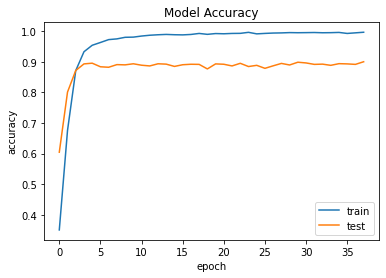

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

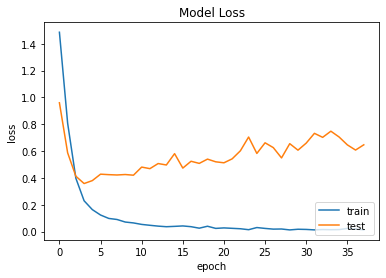

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()